In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, AveragePooling2D, Dense, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras.optimizers import Adam

import os
import time
from gensim.parsing.preprocessing import remove_stopwords
from gensim import models
from pathlib import Path
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from string import digits

In [5]:
data=pd.read_csv('../../data/meta_rotten.csv')
subtitles=pd.read_csv('../../data/movies_subtitles.csv')



In [6]:
# create dataframe with subtitles of every movie

movies_ids=list(subtitles['imdb_id'].unique())
movies_list=[]

for index in movies_ids[:5]:
    globals()['%s' % index]= subtitles.loc[subtitles['imdb_id']==index]
    movies_list.append(globals()['%s' % index])

In [10]:
# load NLU model

model = GPT2LMHeadModel.from_pretrained('gpt2')  
word_embeddings = model.transformer.wte.weight  
position_embeddings = model.transformer.wpe.weight 
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [11]:
# creating the matrix for every movie

remove_digits = str.maketrans('', '', digits) # object to remove numbers

matrix_subtitles=[]#pd.DataFrame(movies_list, columns=["movie"])

for movie in movies_list[:5]:
        
    dimension=int(len(movie)/768)
    low_bound=0
    high_bound=dimension   
 
    movie_words=[]
    
    # for every split of one movie's subtitle get list of words
    for i in range(768):
        text=[]
        subset=movie.iloc[low_bound:high_bound]       
        text+=subset['text'].to_string().split() # split string
        text = [x for x in text if not (x.isdigit())]  # remove numbers (index)
        globals()['sentences_%s' % i]=text
        low_bound+=dimension
        high_bound+=dimension
        movie_words.append(globals()['sentences_%s' % i])  # append list of words to movie_words
        
        
################ split for time complexity????
    matrix=[]

    # for every list of words obtain vector and append to matrix
    for sentence in movie_words:
        sent_vect=[]
        for word in sentence:
            text_index = tokenizer.encode(word,add_prefix_space=True)
            vector = model.transformer.wte.weight[text_index,:]
            vector=vector.detach().numpy()         
            sent_vect.append(vector[0])
        matrix.append(np.sum(sent_vect, axis=0) / len(sent_vect))  
   
    matrix_subtitles.append(np.array(matrix))
    

        

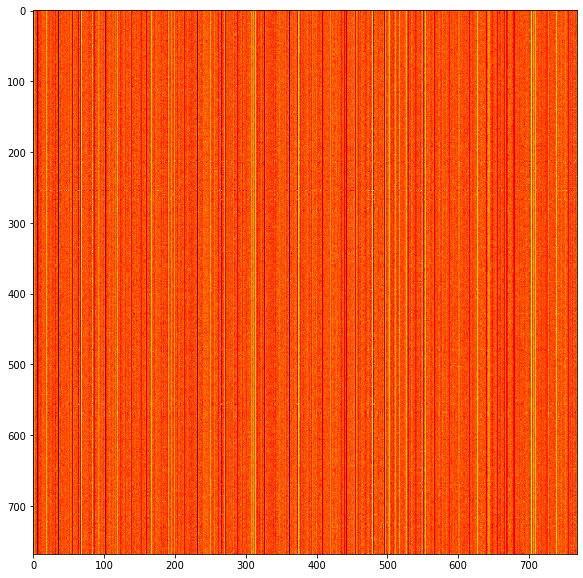

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(matrix_subtitles[3], cmap='hot', interpolation='nearest')
plt.show()

In [4]:
class conv_block():  
    def __init__(self, n_layers, kernel_size=(5, 5), dropout_rate=0.2):
        self.conv = Conv2D(n_layers, kernel_size, activation='relu', padding='same')
        self.conv2 = Conv2D(n_layers*2, kernel_size, activation='relu', padding='same')
        self.conv3 = Conv2D(n_layers*2, kernel_size, activation='relu', padding='same')
        self.conv4 = Conv2D(n_layers, kernel_size, activation='relu', padding='same')      
        self.pooling = AveragePooling2D(2)
        self.bn = BatchNormalization()
        self.dropout = SpatialDropout2D(dropout_rate)
        
    def call(self, x):
        x = self.conv(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pooling(x)
        x = self.bn(x)
        x = self.dropout(x)
        return x
                       
class CNN():
    def __init__(self):
        self.conv_block1 = conv_block(512)
        self.conv_block2 = conv_block(256)
        self.conv_block3 = conv_block(128)
        self.conv_block4 = conv_block(64)        
        self.pool=GlobalAveragePooling2D()  
        self.dense = Dense(3)
        
    def call(self, x):     
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.flatten(x)
        x = self.dense(x)    
        return x


In [1]:
model=CNN()
#model.compile(optimizer=Adam, loss=[accuracy],)
#model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

NameError: name 'CNN' is not defined

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
# https://huggingface.co/docs/transformers/tasks/sequence_classification for transformers classification